In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import logging
import argparse
import glob
import json
from collections import Counter

import numpy as np
import matplotlib
from matplotlib.ticker import StrMethodFormatter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image
from scipy.stats import binom
from IPython.display import display, Markdown

from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config
from zoobot import label_metadata
from zoobot.estimators import losses
from zoobot.estimators import dirichlet_stats


In [3]:
os.chdir('/home/walml/repos/zoobot')

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)


In [5]:
catalog_loc = 'data/gz2/gz2_master_catalog.csv'
catalog = pd.read_csv(catalog_loc, dtype={'subject_id': str})  # original catalog
catalog['file_loc'] = catalog['local_png_loc'].apply(lambda x: '/media/walml/beta/galaxy_zoo/gz2' + x[32:])
catalog['id_str'] = catalog['dr7objid'].apply(lambda x: 'dr7objid_' + str(x))

In [6]:
# label_cols = label_metadata.gz2_label_cols
# questions = label_metadata.gz2_questions

label_cols = label_metadata.gz2_partial_label_cols
questions = label_metadata.gz2_partial_questions

# state_loc = 'results/temp/gz2_all_q_warm_active/iteration_0/state.pickle'
# label_cols = label_metadata.gz2_label_cols
# questions = label_metadata.gz2_questions

version = 'gz2'
schema = losses.Schema(label_cols, questions, version=version)
answer_cols = [a.text for a in schema.answers]

{smooth-or-featured, indices 0 to 1, asked after None: (0, 1)}


In [7]:
concentration_cols = [col + '_concentration' for col in label_cols]
concentration_mean_cols = [col + '_concentration_mean' for col in label_cols]

# for it in it_list:
#     for col in concentration_cols:
#         it[col] = it[col].apply(lambda x: np.array(json.loads(x)))

In [25]:
iterations = range(0, 2) # sometimes skip first
m = 0
n_models = 3  # oops I left this

# optimise spiral, predict 4q
# active_locs = [f'temp/gz2_1q_conc_active_it2_m{n}.csv' for n in range(n_models)]
# baseline_locs = [f'temp/gz2_1q_conc_baseline_it2_m{n}.csv' for n in range(n_models)]


# optimise smooth/feat, predict 1q
data = []
for iteration_n in iterations:
    
#     active_concentrations = []
#     baseline_concentrations = []
    for model_n in range(n_models):

#         if iteration_n > 0:
#             active_loc = f'temp/gz2_1q_1active_it{iteration_n}_m{model_n}_log.csv'
#             baseline_loc = f'temp/gz2_1q_1baseline_it{iteration_n}_m{model_n}_log.csv'
        if iteration_n == 1:
            active_loc = f'temp/gz2_1q_1active_best_it{iteration_n}_m{model_n}.csv'
            baseline_loc = f'temp/gz2_1q_1baseline_it{iteration_n}_m{model_n}_log.csv'
        elif iteration_n == 0:
            active_loc = f'temp/gz2_1q_1active_it{iteration_n}_m{model_n}.csv'
            baseline_loc = f'temp/gz2_1q_1baseline_it{iteration_n}_m{model_n}.csv'


        active_df = pd.read_csv(active_loc)
        baseline_df = pd.read_csv(baseline_loc)

        labels = active_df[answer_cols].values  # same for all

        active_concentration = dirichlet_stats.load_all_concentrations(active_df, concentration_cols)
        baseline_concentration = dirichlet_stats.load_all_concentrations(baseline_df, concentration_cols)

        active_loss = dirichlet_stats.dirichlet_mixture_loss(labels, active_concentration, schema.question_index_groups)
        baseline_loss = dirichlet_stats.dirichlet_mixture_loss(labels, baseline_concentration, schema.question_index_groups)

        active_like = np.exp(-active_loss)  # inverse of neg log likelihood
        baseline_like = np.exp(-baseline_loss)

        data.append({
            'iteration': iteration_n,
            'model': model_n,
            'mode': 'active',
            'mean_loss': active_loss.mean(),
            'mean_like': active_like.mean()
        })
        data.append({
            'iteration': iteration_n,
            'model': model_n,
            'mode': 'baseline',
            'mean_loss': baseline_loss.mean(),
            'mean_like': baseline_like.mean()
        })

# final
final_loc = 'temp/gz2_allq_not_sim_unfiltered_300_offline_1q.csv'
final_df = pd.read_csv(final_loc)
final_concentration = dirichlet_stats.load_all_concentrations(final_df, concentration_cols)
final_loss = dirichlet_stats.dirichlet_mixture_loss(labels, final_concentration, schema.question_index_groups)
final_like = np.exp(-final_loss)  # inverse of neg log likelihood
data.append({
    'iteration': 5,
    'model': 0,
    'mode': 'final',
    'mean_loss': final_loss.mean(),
    'mean_like': final_like.mean()
})

results = pd.DataFrame(data=data)
results.head()

,iteration,model,mode,mean_loss,mean_like
0,0,0,active,2.486559,0.104135
1,0,0,baseline,2.487594,0.104209
2,0,1,active,2.517586,0.103039
3,0,1,baseline,2.520201,0.103090
4,0,2,active,2.561514,0.098703


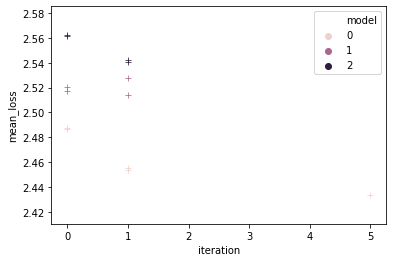

In [31]:
sns.scatterplot(data=results, x='iteration', y='mean_loss', hue='model', marker='+')

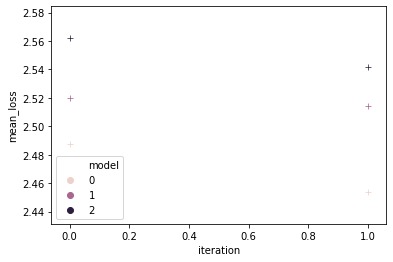

In [26]:
sns.scatterplot(data=results.query('mode=="baseline"'), x='iteration', y='mean_loss', hue='model', marker='+')

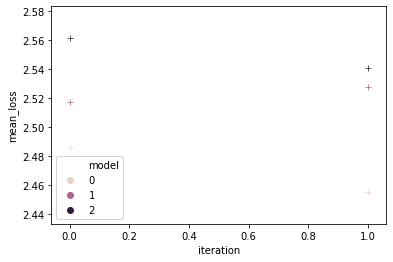

In [30]:
sns.scatterplot(data=results.query('mode=="active"'), x='iteration', y='mean_loss', hue='model', marker='+')

In [37]:
results['model']

0     0
1     0
2     1
3     1
4     2
5     2
6     0
7     0
8     1
9     1
10    2
11    2
12    0
Name: model, dtype: int64

In [49]:
import matplotlib as mpl
cycler = mpl.rcParams['axes.prop_cycle']
# https://matplotlib.org/cycler/
colors = [c['color'] for c in cycler]

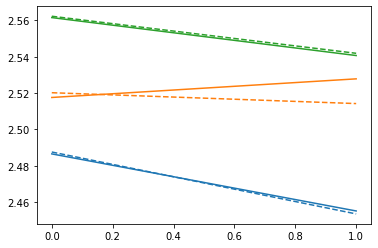

In [50]:

for model_n in range(3):
    color = colors[model_n]
    model = results[(results['iteration'] < 2) & (results['model'] == model_n)]
    baseline = model.query('mode=="baseline"')
    active = model.query('mode=="active"')
    plt.plot(baseline['iteration'], baseline['mean_loss'], linestyle='--', color=color)
    plt.plot(active['iteration'], active['mean_loss'], color=color)
#     plt.plot(results[to_plot])

In [41]:
results[to_plot]

,iteration,model,mode,mean_loss,mean_like
10,1,2,active,2.540648,0.100021
11,1,2,baseline,2.541879,0.101677


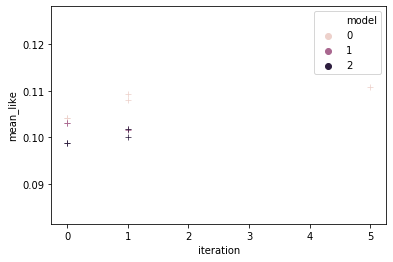

In [29]:
sns.scatterplot(data=results, x='iteration', y='mean_like', hue='model', marker='+')